In [1]:
import numpy                    as np
import scipy.io.wavfile         as wav
import matplotlib.pyplot        as plt
import sklearn.decomposition    as skd
import math
import numpy.linalg as la

In [2]:
def spectrogram(signal, ws = 1024, hs = 512):
    # Author: C. Howard
    # Function to compute the baseline complex valued spectrogram for some input sound signal.
    # signal: a sound represented as a column vector
    # ws    : the window size
    # hs    : the hope size, aka the amount we shift from sample to sample

    # compute Hamming weights
    alpha   = 0.54
    beta    = 1 - alpha
    pi2     = 2.0*math.pi
    c       = pi2/(ws-1)
    w       = alpha - beta * np.cos(c*np.arange(0,ws,1))

    # compute DFT matrix
    p = np.arange(0,ws,1).reshape(ws,1)
    F = np.exp( -(pi2/ws)*np.matmul(p,p.T)*1j )  / np.sqrt(ws)

    # compute resulting local matrix
    D = np.multiply(F,w)

    # Compute number of samples in spectrogram
    (len,c)     = signal.shape
    num_samples = math.floor((len - hs)/(ws - hs))

    # initialize output S
    S = np.zeros((ws,num_samples),dtype=type(F[0,0]))

    # loop through and construct S
    for i in range(0,num_samples):
        S[:ws, i] = np.matmul(D,signal[i*hs:(i*hs+ws),0])

    # return the output spectrogram
    return S[:int(ws/2),:]

In [3]:
def pca( D, numComponents ):
    [U,S,Vt] = la.svd(D, full_matrices = False)
    eigenVectors = U[:, :numComponents]
    return eigenVectors

In [18]:
# https://github.com/akcarsten/Independent_Component_Analysis
def fastICA(whitenedData, alpha = 0.0001, thresh = 1e-12, maxSteps = 5000):
    numPrincipalComponents, numberOfSamples = np.shape(whitenedData)
    # this matrix will be filled column by column 
    W = np.random.rand(numPrincipalComponents,numPrincipalComponents)
    
    # here we loop over all the columns of W, for each column, we try to make it as independent as possible from previous
    # c components
    for c in range(numPrincipalComponents):
      
        # grab the c'th row of the W matrix (component), copy it and reshape it to a m entry column vector
        w = W[c, :].copy().reshape(numPrincipalComponents, 1)
        #w = w / np.sqrt((w ** 2).sum())
        
        # variables used to track the progress of the optimzation: lim will be calculated after each optimzation step and for
        # each component, if it is less than the threshold, we consider that component to be independent from the previous ones
        # this threshold is based on how similar the component is to what it was in the previous step, ie if the component does 
        # not change, we are done. 
        # step is used as a tracker so that we don't stay on any one component for more than maxSteps.
        step = 0
        lim = 100
        
        # Loop until we have reached a component that is not changing over time or we have reached max steps
        while ((lim > thresh) & (step < maxSteps)):
            # follow this algorithm: https://en.wikipedia.org/wiki/FastICA
            
            # Dot product of weight and signal
            ws = w.T @ whitenedData

            # g
            wg = np.tanh(ws * alpha).T

            # g'
            wgPrime = (1 - np.square(np.tanh(ws))) * alpha

            # Update weights
            wNew = (whitenedData * wg.T).mean(axis=1) - wgPrime.mean() * w.squeeze()

            # Decorrelate all weights that we have optimized for independence             
            wNew = wNew - wNew @ W[:c].T @ W[:c]
            wNew = wNew / np.sqrt((wNew ** 2).sum())

            # Calculate limit condition
            lim = np.abs(np.abs((wNew * w).sum()) - 1)

            # Update weights
            w = wNew

            # Update step
            step += 1
        # rebuild up our instance of W using each optimized component
        W[c, :] = w.T
    
    return W

In [19]:
# define the number of features you want
num_features    = 3

# load the sound file and get into proper shape
(freq,signal)   = wav.read('../data/vl1.wav')
N               = signal.shape[0]
signal          = signal.reshape(N,1)

In [20]:
window_size     = 1024
hop_size        = int(window_size/4)
S               = spectrogram(signal,ws=window_size,hs=hop_size)

In [21]:
# find the sqrt of the magnitude of the spectrogram matrix
(r,c)           = S.shape
Sn              = np.abs(S)
Snsq            = np.sqrt(Sn)

# compute mean of spectrogram data
mu_s            = np.matmul(Sn,np.ones((c,1))/c)

# subtract mean from data
Sn_d            = Sn - mu_s

# Perform PCA from zero-mean form of data
principalComponents   = pca(Sn_d,num_features)

In [22]:
# perform ICA
pcaProj = principalComponents.T @ Sn_d
W = fastICA(pcaProj)
S = W @ principalComponents.T
print(np.shape(S))

(3, 512)


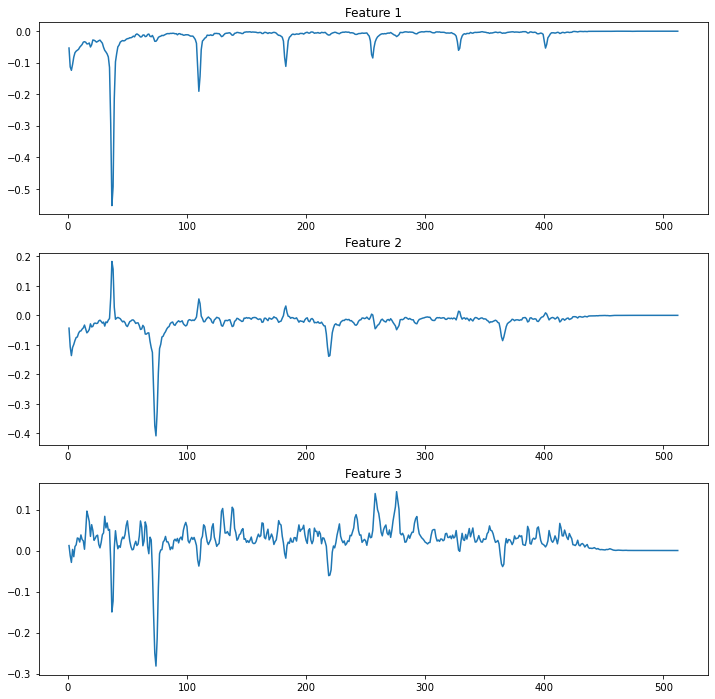

In [23]:
ind = 1 + np.arange(0, int(window_size/2))
fig, ax1 = plt.subplots(nrows = 3, ncols = 1)

for k in range(0,3):
    ax1[k].plot(ind, principalComponents[:, k])
    ax1[k].set_title('Feature '+str(k+1))
fig.set_figheight(12)
fig.set_figwidth(12) 

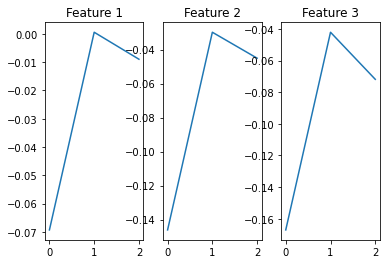

In [24]:
# plot ICA features
    fg2, ax2 = plt.subplots(nrows=1, ncols=3)

    for k in range(0, 3):
        ax2[k].plot(S[:, k])
        ax2[k].set_title('Feature ' + str(k + 1))